#  Générer les statistiques usager

**Description** : Le but de ce notebook est de générer des statistiques sur le suivi des usagers. Un fichier user_statistics a déjà été livré par Motiontag mais celui-ci donne des statistiques sur une période donnée (2023-04-24--2023-06-05), or la date de début et de fin de tracking pour chaque répondant peut être variable. Notre objectif est donc de reproduire le fichier user_statistics par individu.

**Objectifs spécifiques** :
- [ ] Obtenir le nombre de jours avec observation et le nombre de jour non-détecté 
- [ ] Connaître les périodes d'observaiton pour chaque personne
- [ ] Connaître le canton de résidence de chaque répondant·e
- [ ] Ajouter des variables fournies par Motiontag sur les devices

**Résultats attendus** : Un fichier avec une ligne par répondant·e.

**Sous-échantillonnage** :
Tout l'échantillon

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from shapely import geometry, ops
from shapely.geometry import MultiLineString, LineString, Point
import os
import concurrent.futures
from shapely.ops import unary_union
import xyt

import time

from panel_functions import *

### Charger les données

In [4]:
%%time
# Définir le CRS du projet (EPSG:4326 for WGS84)
target_crs = 'EPSG:4326'
print("CRS du projet: WGS84 \n")

#Charger les étapes
legs = pd.read_pickle('../Data/dumps_motiontag/storyline_time_space_filters/legs.pkl')
print("Fichier étape chargé")

#Charger les activités
staypoints = pd.read_pickle('../Data/dumps_motiontag/storyline_formated/staypoints.pkl')
#staypoints = gpd.GeoDataFrame(staypoints, geometry="geometry", crs=target_crs)
print("Fichier activité chargé")


#Charger le questionnaire de la Vague 1 Mobilité pour Domicile déclaré
columns_to_keep = ['longitude_Q14', 'latitude_Q14', 'IDNO', 'Pays', 'Numéro_INSEE', 'Numéro_OFS']
home_declared = pd.read_csv('../../Vague1/EPFL_vague1_v4.csv', low_memory=False, usecols=columns_to_keep)
#Remove those who did not declare any address
home_declared = home_declared[home_declared.longitude_Q14 > 0]
# Create a geometry column from longitude and latitude
geometry = [Point(xy) for xy in zip(home_declared['longitude_Q14'], home_declared['latitude_Q14'])]
# Combine Numéro_INSEE and Numéro_OFS into a single column 'ID_municipality'
home_declared['ID_municipality_survey'] = home_declared.apply(lambda x: x['Numéro_OFS'] if x['Pays'] == '1' else x['Numéro_INSEE'], axis=1)
home_declared = home_declared.drop(columns=['Numéro_OFS', 'Numéro_INSEE', 'longitude_Q14','latitude_Q14'])
# Create a GeoDataFrame
home_declared = gpd.GeoDataFrame(home_declared, geometry=geometry, crs=target_crs)
home_declared = home_declared.rename(columns={'geometry':'home_geometry_from_survey','IDNO':'user_id_fors'})
home_declared = gpd.GeoDataFrame(home_declared, geometry='home_geometry_from_survey', crs=target_crs)
print("Fichier domicile chargé")

#Charger le fichier user_statistics livré par Motiontag mais inexploitable
usr_stat_motion_tag  = pd.read_csv('../Data/dumps_motiontag/UserStatistics.EPFL-Panel.2023-04-24--2023-06-05.csv', sep=';')
print("Fichier user_statistics chargé (FORS et Motiontag)")

#Charger le fichier de pondération par Alexis Gumy
weights = pd.read_csv('../Data/weights_lasur/data_wgt.csv', sep=',').rename(columns={'IDNO':'user_id_fors'})
w_cols = ['gdr','prof','age_fr','user_id_fors','wgt_cant_gps','wgt_agg_gps','wgt_cant_trim_gps','wgt_agg_trim_gps']
weights = weights[w_cols]
print("Fichier de pondération chargé")

#Charger le questionnaire de la Vague 1 Mobilité
full_survey = pd.read_csv('../../Vague1/EPFL_vague1_v4.csv', low_memory=False)
print("Fichier Questionnaire vague 1 chargé")

#Charger les bases officielles pour le sous-échantillonage géographique https://opendata.swiss/de/dataset/vm-uvek-zones-2017/resource/29b98f2c-42f2-4e72-b8b1-a39500ed0ad0
TAZ = gpd.read_file('../../Vague1/Verkehrszonen_Schweiz_NPVM_2017_shp/Verkehrszonen_Schweiz_NPVM_2017.shp')
TAZ = TAZ[['ID_Agglo', 'N_Agglo', 'N_KT', 'ID_Gem', 'geometry']]
TAZ = TAZ.to_crs(crs=target_crs)
#repare anomalies
TAZ['geometry'] = TAZ['geometry'].buffer(0)
shp_KT = TAZ.dissolve(by='N_KT').reset_index()
print("Fichier Zones de traffic chargé")

#Charger la table de correspondance entre les userid Motiontag et FORS
match_userid = pd.read_csv('../Data/dumps_fors/correspondance_user_id.csv')
print("Fichier table de correspondance user id chargé")

CRS du projet: WGS84 

Fichier étape chargé
Fichier activité chargé
Fichier domicile chargé
Fichier user_statistics chargé (FORS et Motiontag)
Fichier de pondération chargé
Fichier Questionnaire vague 1 chargé
Fichier Zones de traffic chargé
Fichier table de correspondance user id chargé
CPU times: user 18.6 s, sys: 9.01 s, total: 27.7 s
Wall time: 33.4 s


###  Aperçu des données

In [5]:
staypoints.head(2)

,activity_id,user_id_motiontag,type,started_at,started_at_timezone,finished_at,finished_at_timezone,purpose,geometry,confirmed_at,started_on,misdetected_completely,merged,created_at,updated_at,started_at_in_timezone,finished_at_in_timezone,confirmed_at_in_timezone,created_at_in_timezone,updated_at_in_timezone,user_id_fors,lon,lat
0,75074f7e-43cf-45ba-85a1-870d3ef09a4e,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,Stay,2023-04-30 12:12:28,Europe/Zurich,2023-05-01 05:10:22,Europe/Zurich,home,POINT (6.53632 46.73239),2023-05-21 11:26:59.748,2023-04-30,f,f,2023-05-01 15:29:57.981,2023-05-21 11:26:59.748,2023-04-30T14:12:28+02:00,2023-05-01T07:10:22+02:00,2023-05-21T11:26:59Z,2023-05-01T15:29:57Z,2023-05-21T11:26:59Z,CH3181,6.536317,46.732394
1,4311fb87-42d1-4950-b330-f06a18459bc1,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,Stay,2023-05-01 05:16:18,Europe/Zurich,2023-05-01 15:11:05,Europe/Zurich,work,POINT (6.56977 46.70299),2023-05-01 19:41:19.314,2023-05-01,f,f,2023-05-01 15:29:58.084,2023-05-01 19:41:19.314,2023-05-01T07:16:18+02:00,2023-05-01T17:11:05+02:00,2023-05-01T19:41:19Z,2023-05-01T15:29:58Z,2023-05-01T19:41:19Z,CH3181,6.569772,46.702987


In [6]:
legs.head(2)

,leg_id,user_id_motiontag,type,started_at,started_at_timezone,finished_at,finished_at_timezone,length,detected_mode,mode,purpose,geometry,confirmed_at,started_on,misdetected_completely,merged,created_at,updated_at,started_at_in_timezone,finished_at_in_timezone,confirmed_at_in_timezone,created_at_in_timezone,updated_at_in_timezone,point_per_linestring,max_signlalloss_meters,length_leg,rel_max_signalloss,low_quality_legs_1,low_quality_legs_2,usr_w_constant_bad_signal,user_id_fors
0,051d1613-b29a-4598-90d4-2365bf58132b,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,Track,2023-05-01 05:10:22,Europe/Zurich,2023-05-01 05:16:18,Europe/Zurich,4999.0,Mode::Car,Mode::Car,NaN,"LINESTRING (6.53632 46.73239, 6.53632 46.73239...",2023-05-01 19:41:23.435,2023-05-01,f,f,2023-05-01 15:29:57.991,2023-05-02 18:32:09.853,2023-05-01T07:10:22+02:00,2023-05-01T07:16:18+02:00,2023-05-01T19:41:23Z,2023-05-01T15:29:57Z,2023-05-02T18:32:09Z,67,368.918417,5000.050971,0.073783,0,0,0,CH3181
1,92957703-71b4-4ae0-a1d2-3a2862d74a43,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,Track,2023-05-01 15:11:05,Europe/Zurich,2023-05-01 15:20:08,Europe/Zurich,5668.0,Mode::Car,Mode::Car,NaN,"LINESTRING (6.56977 46.70299, 6.56977 46.70299...",2023-05-01 19:41:16.858,2023-05-01,f,f,2023-05-01 15:29:58.093,2023-05-01 19:41:16.858,2023-05-01T17:11:05+02:00,2023-05-01T17:20:08+02:00,2023-05-01T19:41:16Z,2023-05-01T15:29:58Z,2023-05-01T19:41:16Z,105,115.033745,5667.945056,0.020295,0,0,0,CH3181


### Calculer les statistiques par répondant·e

####  Get usr activity statistics based on staypoints

In [7]:
def get_user_activity_stats(staypoints):
    
    # Make a copy to avoid error
    count_act = staypoints.copy()
    
    # Convert 'started_at' column to datetime
    count_act['started_at'] = pd.to_datetime(count_act['started_at'])

    # Extract only the date part
    count_act['date'] = count_act['started_at'].dt.date

    # Group by 'user_id_motiontag', then find the min and max dates
    user_stats = count_act.groupby(['user_id_motiontag','user_id_fors'])['date'].agg(['min', 'max']).reset_index()

    # Calculate the total days in the range for each user
    user_stats['days_in_range'] = (pd.to_datetime(user_stats['max']) - pd.to_datetime(user_stats['min'])).dt.days + 1

    # Create a date range covering the entire date range for each user
    date_ranges = user_stats.apply(lambda row: pd.date_range(row['min'], row['max'], freq='D'), axis=1)
    user_stats['date_range'] = date_ranges

   # Group by 'user_id_motiontag' and count the unique dates
    user_unique_dates = count_act.groupby('user_id_motiontag')['date'].nunique().reset_index()

    # Merge with user_unique_dates to get active_days_count
    user_stats = pd.merge(user_stats, user_unique_dates, on='user_id_motiontag', how='left')
    user_stats.rename(columns={'date': 'active_days_count'}, inplace=True)

    # Calculate the number of missing days within the range for each user
    user_stats['days_without_event'] = user_stats['days_in_range'] - user_stats['active_days_count']

    # Drop unnecessary columns
    user_stats.drop(columns=['date_range'], inplace=True)

    # Rename the min/may columns
    user_stats.rename(columns={'min':'first_activity_date','max':'last_activity_date'}, inplace=True)

    return user_stats

In [8]:
usr_stats = get_user_activity_stats(staypoints)

In [9]:
# IMPORTANT Check the value of active_days_count
#id_ = 'CH10068'
#usr_stats[usr_stats.user_id_motiontag == id_]['active_days_count'].iloc[0]

In [10]:
# Must be identical to:
#len(count_act[count_act.user_id == id_].date.unique())

In [11]:
usr_stats = pd.merge(usr_stats, 
                     get_user_activity_stats(legs).rename(columns={'active_days_count':'days_with_track','days_without_event':'days_without_track'}),#[['user_id_motiontag','days_without_track']],
                    on=['user_id_motiontag','user_id_fors'],
                    how='left')

usr_stats.loc[~usr_stats.user_id_motiontag.isin(legs.user_id_motiontag.unique().tolist()),'days_without_track'] = 99

usr_stats['days_without_track'] = usr_stats['days_without_track'].astype(int)

#### Get the max period of observation between legs and staypoints

In [12]:
# Convert date columns to datetime
date_cols = ['first_activity_date_x', 'last_activity_date_x', 'first_activity_date_y', 'last_activity_date_y']
usr_stats[date_cols] = usr_stats[date_cols].apply(pd.to_datetime)

# Calculate new columns
usr_stats['first_activity_date'] = usr_stats[['first_activity_date_x', 'first_activity_date_y']].min(axis=1)
usr_stats['last_activity_date'] = usr_stats[['last_activity_date_x', 'last_activity_date_y']].max(axis=1)
usr_stats['days_in_range'] = usr_stats[['days_in_range_x', 'days_in_range_y']].max(axis=1)

# Drop old columns
columns_to_drop = ['first_activity_date_x', 'last_activity_date_x', 'days_in_range_x',
                   'first_activity_date_y', 'last_activity_date_y', 'days_in_range_y']
usr_stats = usr_stats.drop(columns=columns_to_drop)

#### Add stats from Motiontag user_stat file

In [13]:
#Add
merge_on_col = ['id','confirmed_tracks_count','unconfirmed_tracks_count','tracks_count']
usr_stats = pd.merge(usr_stats,
                     usr_stat_motion_tag[merge_on_col].rename(columns={'id':'user_id_motiontag'}),
                     how='left', on='user_id_motiontag')
#Reorder columns
cols = ['user_id_motiontag', 'user_id_fors', 
 'first_activity_date', 'last_activity_date', 'days_in_range', 'active_days_count',
 'days_without_event', 'days_with_track', 'days_without_track',
 'confirmed_tracks_count','unconfirmed_tracks_count','tracks_count']
usr_stats = usr_stats[cols]

In [14]:
usr_stats.head()

,user_id_motiontag,user_id_fors,first_activity_date,last_activity_date,days_in_range,active_days_count,days_without_event,days_with_track,days_without_track,confirmed_tracks_count,unconfirmed_tracks_count,tracks_count
0,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,CH3181,2023-04-30,2023-06-05,37,33,4,32,4,210,0,210
1,001807b0-d393-47f1-be7d-a28708ab38b8,CH7869,2023-05-04,2023-06-05,33,18,15,11,19,21,0,21
2,0022452b-97e0-4e5f-b01e-1168e92364e6,CH23573,2023-04-24,2023-06-01,39,39,0,38,0,4,280,284
3,00284b1d-cc9c-46a7-9877-d5ab9aad7fd4,CH1007,2023-05-02,2023-05-31,30,23,6,24,6,269,1,270
4,00367e58-ad00-41db-b93b-1f1e55c5a733,CH26652,2023-05-11,2023-06-05,26,20,6,20,6,164,1,165


#### Add home location from GPS data

In [15]:
%%time 
# Obtenir la localisation du domicile sur la base des données GPS
import pandas as pd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Step 1: Convert the 'geometry' column to Shapely Point objects and remove nans
staypoints_ = staypoints.loc[staypoints.purpose == 'home'].copy()#.dropna()

# Step 2: Define a function to cluster points within a specified radius using 'lon' and 'lat' columns
def cluster_points(points_, eps, min_samples):
    """
    Clusters points using DBSCAN algorithm.

    Parameters:
        points_ (DataFrame): DataFrame with 'lon' and 'lat' columns.
        eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

    Returns:
        List of cluster labels for each input point.
    """

    points = points_.copy()
    
    # Check if DataFrame is empty
    if points.empty:
        return []
    
    scaler = StandardScaler()
    scaled_points = scaler.fit_transform(points[['lon', 'lat']])

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(scaled_points)

    return dbscan.labels_

# Step 3: Apply the clustering function to your points
staypoints_['cluster'] = cluster_points(staypoints_, eps=0.00045, min_samples=15)

# Step 4: Define a function to calculate the centroid of each cluster
def calculate_centroid(points):
    """
    Calculates the centroid of a list of points.

    Parameters:
        points (DataFrame): DataFrame with 'lon' and 'lat' columns.

    Returns:
        Centroid Point object.
    """
    centroid_lon = points['lon'].mean()
    centroid_lat = points['lat'].mean()
    return Point(centroid_lon, centroid_lat)

# Step 5: Create a list to store the most recurrent cluster for each user_id
most_recurrent_clusters = []

# Step 6: Calculate the most recurrent cluster for each user_id and store its centroid
for user_id, user_group in staypoints_.groupby('user_id_motiontag'):
    cluster_counts = user_group['cluster'].value_counts()
    most_recurrent_cluster = cluster_counts.idxmax()
    
    # Get the group of points for the most recurrent cluster
    most_recurrent_group = user_group[user_group['cluster'] == most_recurrent_cluster]
    
    # Calculate the centroid for the most recurrent cluster group
    centroid = calculate_centroid(most_recurrent_group)
    
    most_recurrent_clusters.append({'user_id_motiontag': user_id, 'centroid': centroid})

# Step 7: Create a new DataFrame from the most_recurrent_clusters list
most_recurrent_clusters_df = pd.DataFrame(most_recurrent_clusters)

# Step 8: Prepare for merging
most_recurrent_clusters_df.rename(columns={'centroid':'home_geometry_from_gps'}, inplace=True)


CPU times: user 3.41 s, sys: 87 ms, total: 3.49 s
Wall time: 3.55 s


In [16]:
usr_stats = pd.merge(usr_stats,most_recurrent_clusters_df,how='left', on='user_id_motiontag')


#### Add home location from declaration in survey

In [17]:
usr_stats = pd.merge(usr_stats,home_declared,how='left', on='user_id_fors')

In [18]:
%%time
usr_stats = gpd.GeoDataFrame(usr_stats, geometry="home_geometry_from_survey", crs=target_crs)
usr_stats = gpd.sjoin(usr_stats, 
                      shp_KT.rename(columns={'N_KT':'KT_home_survey','ID_Agglo':'ID_Agglo_survey','N_Agglo':'N_Agglo_survey'}), 
                      how='left', predicate='intersects')
del usr_stats['index_right']
usr_stats[['ID_Gem','ID_Agglo_survey']] = usr_stats[['ID_Gem','ID_Agglo_survey']].astype(int, errors='ignore') 

usr_stats = gpd.GeoDataFrame(usr_stats, geometry="home_geometry_from_gps", crs=target_crs)
usr_stats = gpd.sjoin(usr_stats, 
                      shp_KT[['N_KT','geometry']].rename(columns={'N_KT':'KT_home_gps'}), 
                      how='left', predicate='intersects')
del usr_stats['index_right']
usr_stats = gpd.GeoDataFrame(usr_stats, geometry="home_geometry_from_survey", crs=target_crs)

CPU times: user 569 ms, sys: 3.67 ms, total: 573 ms
Wall time: 574 ms


**Note: we have to remove 8 usrs with no user_id_fors**

In [19]:
usr_stats.iloc[np.where(usr_stats['user_id_fors'].str.startswith('FR').isna())].head(2)

,user_id_motiontag,user_id_fors,first_activity_date,last_activity_date,days_in_range,active_days_count,days_without_event,days_with_track,days_without_track,confirmed_tracks_count,unconfirmed_tracks_count,tracks_count,home_geometry_from_gps,Pays,ID_municipality_survey,home_geometry_from_survey,KT_home_survey,ID_Agglo_survey,N_Agglo_survey,ID_Gem,KT_home_gps


In [20]:
usr_stats.dropna(subset='user_id_fors',inplace=True)

In [21]:
# Create a boolean mask for rows that start with 'FR'
mask = usr_stats['user_id_fors'].str.startswith('FR')

# Use the boolean mask to filter rows and then assign values
usr_stats.loc[mask, ['KT_home_gps', 'KT_home_survey', 'N_Agglo_survey']] = 'FRA'
usr_stats.loc[mask, ['ID_Agglo_survey', 'ID_Gem']] = 99

# Fill NaN values in 'ID_Gem' and 'ID_Agglo_survey' columns with 99
usr_stats['ID_Gem'] = usr_stats['ID_Gem'].fillna(99).astype(int)
usr_stats['ID_Agglo_survey'] = usr_stats['ID_Agglo_survey'].fillna(99).astype(int)

# Calculate 'days_with_track' column
usr_stats['days_with_track'] = usr_stats['active_days_count'] - usr_stats['days_without_track']


In [22]:
reorder_cols = ['user_id_fors', 'user_id_motiontag', 
 'KT_home_survey', 'KT_home_gps',
 'first_activity_date', 'last_activity_date',
 'days_in_range', 'active_days_count', 'days_without_event','days_with_track','days_without_track', 
 'home_geometry_from_gps', 'home_geometry_from_survey',
 'ID_municipality_survey', 'ID_Agglo_survey', 'N_Agglo_survey']

usr_stats = usr_stats[reorder_cols]
usr_stats = gpd.GeoDataFrame(usr_stats, geometry="home_geometry_from_survey", crs=target_crs)

#### Ajouter les pondérations

In [23]:
usr_stats = pd.merge(usr_stats, weights, on='user_id_fors', how='left')

In [24]:
usr_stats.head()

,user_id_fors,user_id_motiontag,KT_home_survey,KT_home_gps,first_activity_date,last_activity_date,days_in_range,active_days_count,days_without_event,days_with_track,days_without_track,home_geometry_from_gps,home_geometry_from_survey,ID_municipality_survey,ID_Agglo_survey,N_Agglo_survey,gdr,prof,age_fr,wgt_cant_gps,wgt_agg_gps,wgt_cant_trim_gps,wgt_agg_trim_gps
0,CH3181,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,VD,VD,2023-04-30,2023-06-05,37,33,4,29,4,POINT (6.53632 46.73237),POINT (6.53629 46.73239),5757,6153,Monthey,Femme,Population active occupée,30-44 ans,0.296419,0.304223,0.296419,0.304223
1,CH7869,001807b0-d393-47f1-be7d-a28708ab38b8,VD,VD,2023-05-04,2023-06-05,33,18,15,-1,19,POINT (6.59279 46.54076),POINT (6.59211 46.54074),5410,6153,Monthey,Femme,Population active occupée,60-74 ans,0.906823,0.972201,0.906823,0.972201
2,CH23573,0022452b-97e0-4e5f-b01e-1168e92364e6,NaN,VD,2023-04-24,2023-06-01,39,39,0,39,0,POINT (6.63667 46.78205),None,NaN,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CH1007,00284b1d-cc9c-46a7-9877-d5ab9aad7fd4,VD,NaN,2023-05-02,2023-05-31,30,23,6,17,6,POINT (8.22003 46.19169),POINT (6.61431 46.53175),5586,6153,Monthey,Femme,Population active occupée,30-44 ans,0.301482,0.323217,0.301482,0.323217
4,CH26652,00367e58-ad00-41db-b93b-1f1e55c5a733,VD,VD,2023-05-11,2023-06-05,26,20,6,14,6,POINT (6.74324 46.79801),POINT (6.74555 46.79948),5939,6153,Monthey,Homme,Population active occupée,18-29 ans,0.455058,0.467038,0.455058,0.467038


#### Ajouter la motorisation des répondant·es

In [25]:
motor_map = {
    1: 'essence',
    2: 'diesel',
    3: 'electrique',
    4: 'hybride rechargeable',
    5: 'hybride nonrechargeable',
    6: 'gaznat_biogaz',
    7: 'GPL'
}

# Selecting columns
motorization = full_survey[['IDNO','Q4_1_1_R', 'Q4_1_2_R', 'Q5_R']].rename(columns={'Q5_R':'main_motor','IDNO':'user_id_fors'}).set_index('user_id_fors').copy()
# Replacing '#NULL!' and '-99' with NaN
motorization.replace(to_replace={'#NULL!': np.nan, '-99': np.nan}, inplace=True)
# Converting columns to float
motorization = motorization.astype(float)
# Summing the columns and creating a new 'car_in_HH' column
motorization['car_in_HH_count'] = motorization[['Q4_1_1_R', 'Q4_1_2_R']].sum(axis=1)
# Dropping the individual columns if needed
motorization.drop(columns=['Q4_1_1_R', 'Q4_1_2_R'], inplace=True)
# Mapping values in 'Q5_R' column
motorization['main_motor'] = motorization['main_motor'].map(motor_map)
# Reset index
motorization = motorization.reset_index()

usr_stats = pd.merge(usr_stats, motorization, on='user_id_fors',how='left')


#### Sauvegarde du fichier user_statistics

In [26]:
usr_stats.to_pickle('../Data/processed_feuille_de_route/gps_user_statistics.pkl')
usr_stats.to_csv('../Data/processed_feuille_de_route/gps_user_statistics.csv')

In [27]:
usr_stats

,user_id_fors,user_id_motiontag,KT_home_survey,KT_home_gps,first_activity_date,last_activity_date,days_in_range,active_days_count,days_without_event,days_with_track,days_without_track,home_geometry_from_gps,home_geometry_from_survey,ID_municipality_survey,ID_Agglo_survey,N_Agglo_survey,gdr,prof,age_fr,wgt_cant_gps,wgt_agg_gps,wgt_cant_trim_gps,wgt_agg_trim_gps,main_motor,car_in_HH_count
0,CH3181,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,VD,VD,2023-04-30,2023-06-05,37,33,4,29,4,POINT (6.53632 46.73237),POINT (6.53629 46.73239),5757,6153,Monthey,Femme,Population active occupée,30-44 ans,0.296419,0.304223,0.296419,0.304223,essence,1.0
1,CH7869,001807b0-d393-47f1-be7d-a28708ab38b8,VD,VD,2023-05-04,2023-06-05,33,18,15,-1,19,POINT (6.59279 46.54076),POINT (6.59211 46.54074),5410,6153,Monthey,Femme,Population active occupée,60-74 ans,0.906823,0.972201,0.906823,0.972201,essence,1.0
2,CH23573,0022452b-97e0-4e5f-b01e-1168e92364e6,NaN,VD,2023-04-24,2023-06-01,39,39,0,39,0,POINT (6.63667 46.78205),None,NaN,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,CH1007,00284b1d-cc9c-46a7-9877-d5ab9aad7fd4,VD,NaN,2023-05-02,2023-05-31,30,23,6,17,6,POINT (8.22003 46.19169),POINT (6.61431 46.53175),5586,6153,Monthey,Femme,Population active occupée,30-44 ans,0.301482,0.323217,0.301482,0.323217,NaN,0.0
4,CH26652,00367e58-ad00-41db-b93b-1f1e55c5a733,VD,VD,2023-05-11,2023-06-05,26,20,6,14,6,POINT (6.74324 46.79801),POINT (6.74555 46.79948),5939,6153,Monthey,Homme,Population active occupée,18-29 ans,0.455058,0.467038,0.455058,0.467038,essence,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799,CH8750,ffaa5d6b-288b-46ed-800d-ef8e4ab42512,GE,GE,2023-04-25,2023-06-02,39,36,3,33,3,POINT (6.17954 46.19239),POINT (6.17954 46.19220),6621,6621,Genève,Homme,Population active occupée,30-44 ans,0.887434,0.995842,0.887434,0.995842,essence,4.0
2800,CH19818,ffb32fa8-79c7-4360-9025-552fb8ca149b,VD,VD,2023-05-02,2023-06-02,32,32,0,32,0,POINT (6.95434 46.32195),POINT (6.97057 46.31903),5401,6153,Monthey,Femme,Population active occupée,30-44 ans,0.607275,0.447643,0.607275,0.447643,essence,2.0
2801,CH23315,ffc1f825-f35b-4065-97c0-f761856c142d,VD,VD,2023-04-24,2023-06-03,41,38,3,35,3,POINT (6.57776 46.62315),POINT (6.57733 46.62799),5471,6153,Monthey,Homme,Personnes en formation,18-29 ans,0.648241,0.665307,0.648241,0.665307,essence,3.0
2802,FR12202,ffe06c6e-3ddb-4e3f-ae40-1506e85a16c7,FRA,FRA,2023-05-10,2023-06-05,27,21,6,15,6,POINT (6.62502 46.39833),POINT (6.62512 46.39822),74200,99,FRA,Femme,Population active occupée,30-44 ans,0.123956,0.204727,0.123956,0.204727,diesel,2.0


In [28]:
usr_stats_nogeometry = usr_stats.copy()
#usr_stats_nogeometry['home_geometry_from_survey'] = np.nan
#usr_stats_nogeometry['home_geometry_from_gps'] = np.nan
del usr_stats_nogeometry['home_geometry_from_survey']
del usr_stats_nogeometry['home_geometry_from_gps']
del usr_stats_nogeometry['user_id_motiontag']
usr_stats_nogeometry.to_pickle('../Data/processed_feuille_de_route/usr_stats_nogeometry.pkl')

In [29]:
usr_stats_nogeometry#.columns

,user_id_fors,KT_home_survey,KT_home_gps,first_activity_date,last_activity_date,days_in_range,active_days_count,days_without_event,days_with_track,days_without_track,ID_municipality_survey,ID_Agglo_survey,N_Agglo_survey,gdr,prof,age_fr,wgt_cant_gps,wgt_agg_gps,wgt_cant_trim_gps,wgt_agg_trim_gps,main_motor,car_in_HH_count
0,CH3181,VD,VD,2023-04-30,2023-06-05,37,33,4,29,4,5757,6153,Monthey,Femme,Population active occupée,30-44 ans,0.296419,0.304223,0.296419,0.304223,essence,1.0
1,CH7869,VD,VD,2023-05-04,2023-06-05,33,18,15,-1,19,5410,6153,Monthey,Femme,Population active occupée,60-74 ans,0.906823,0.972201,0.906823,0.972201,essence,1.0
2,CH23573,NaN,VD,2023-04-24,2023-06-01,39,39,0,39,0,NaN,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,CH1007,VD,NaN,2023-05-02,2023-05-31,30,23,6,17,6,5586,6153,Monthey,Femme,Population active occupée,30-44 ans,0.301482,0.323217,0.301482,0.323217,NaN,0.0
4,CH26652,VD,VD,2023-05-11,2023-06-05,26,20,6,14,6,5939,6153,Monthey,Homme,Population active occupée,18-29 ans,0.455058,0.467038,0.455058,0.467038,essence,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799,CH8750,GE,GE,2023-04-25,2023-06-02,39,36,3,33,3,6621,6621,Genève,Homme,Population active occupée,30-44 ans,0.887434,0.995842,0.887434,0.995842,essence,4.0
2800,CH19818,VD,VD,2023-05-02,2023-06-02,32,32,0,32,0,5401,6153,Monthey,Femme,Population active occupée,30-44 ans,0.607275,0.447643,0.607275,0.447643,essence,2.0
2801,CH23315,VD,VD,2023-04-24,2023-06-03,41,38,3,35,3,5471,6153,Monthey,Homme,Personnes en formation,18-29 ans,0.648241,0.665307,0.648241,0.665307,essence,3.0
2802,FR12202,FRA,FRA,2023-05-10,2023-06-05,27,21,6,15,6,74200,99,FRA,Femme,Population active occupée,30-44 ans,0.123956,0.204727,0.123956,0.204727,diesel,2.0


# Eléments remarquables de user_stats 

In [39]:
len(usr_stats.loc[usr_stats['days_without_event']>10])

295

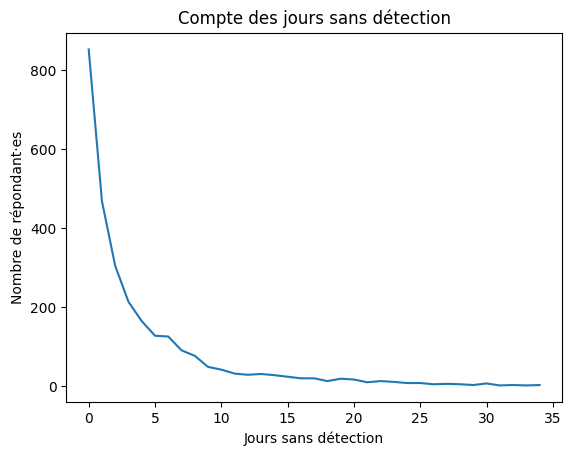

In [34]:
import matplotlib.pyplot as plt

# Assuming usr_stats is your DataFrame
usr_stats['days_without_event'].value_counts().sort_index().plot(kind='line')

# Adding labels and title
plt.xlabel('Jours sans détection')
plt.ylabel('Nombre de répondant·es')
plt.title('Compte des jours sans détection')

# Display the plot
plt.show()


In [30]:
len(usr_stats[usr_stats.KT_home_survey != usr_stats.KT_home_gps])

242

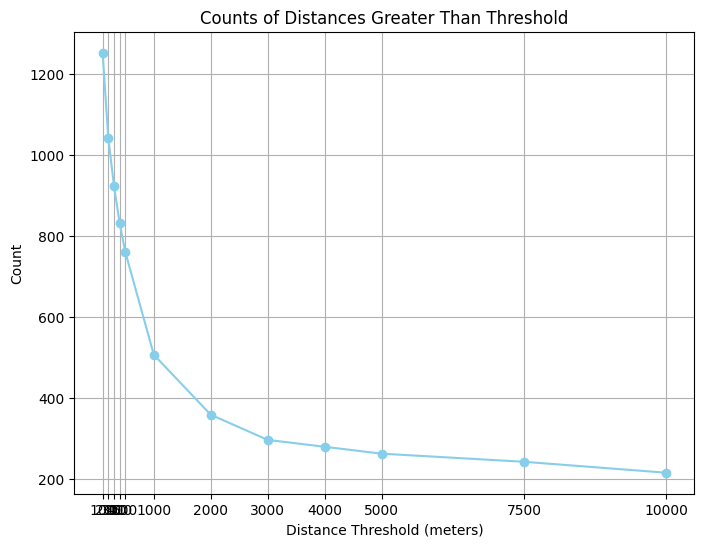

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Sample GeoDataFrame usr_stats with 'home_geometry_from_gps' and 'home_geometry_from_survey' columns
# Assuming the initial CRS is EPSG:4326 (WGS84)

# Define the target CRS in meters
target_crs_meters = 'EPSG:2056'  # Web Mercator

# Convert the 'home_geometry_from_gps' and 'home_geometry_from_survey' columns to the target CRS
usr_stats['home_geometry_from_gps_m'] = usr_stats['home_geometry_from_gps'].to_crs(target_crs_meters)
usr_stats['home_geometry_from_survey_m'] = usr_stats['home_geometry_from_survey'].to_crs(target_crs_meters)

# Calculate the distances in meters
usr_stats['distance_home_gps_survey_m'] = usr_stats['home_geometry_from_gps_m'].distance(usr_stats['home_geometry_from_survey_m'])

# Define the distance thresholds
distance_thresholds = [100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000]  
  # Add more thresholds as needed

# Count occurrences for each threshold
count_per_threshold = []
for threshold in distance_thresholds:
    count = usr_stats['distance_home_gps_survey_m'][usr_stats['distance_home_gps_survey_m'] > threshold].count()
    count_per_threshold.append(count)

# Plotting the distribution of distances for each threshold as a line chart
plt.figure(figsize=(8, 6))
plt.plot(distance_thresholds, count_per_threshold, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Distance Threshold (meters)')
plt.ylabel('Count')
plt.title('Counts of Distances Greater Than Threshold')
plt.grid(True)
plt.xticks(distance_thresholds)
plt.show()
